In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, KFold
from sklearn.feature_selection import f_regression
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import warnings
warnings.filterwarnings("ignore")

In [54]:
# read data
data = pd.read_csv("Melbourne_housing.csv")

# remove any unnamed columns
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 21 columns):
Suburb           499 non-null object
Address          499 non-null object
Rooms            499 non-null int64
Type             499 non-null object
Price            391 non-null float64
Method           499 non-null object
SellerG          499 non-null object
Date             499 non-null object
Distance         499 non-null float64
Postcode         499 non-null int64
Bedroom2         371 non-null float64
Bathroom         371 non-null float64
Car              362 non-null float64
Landsize         325 non-null float64
BuildingArea     189 non-null float64
YearBuilt        212 non-null float64
CouncilArea      499 non-null object
Lattitude        377 non-null float64
Longtitude       377 non-null float64
Regionname       499 non-null object
Propertycount    499 non-null int64
dtypes: float64(10), int64(3), object(8)
memory usage: 82.0+ KB


### Question 1: Data Exploration and Visualization

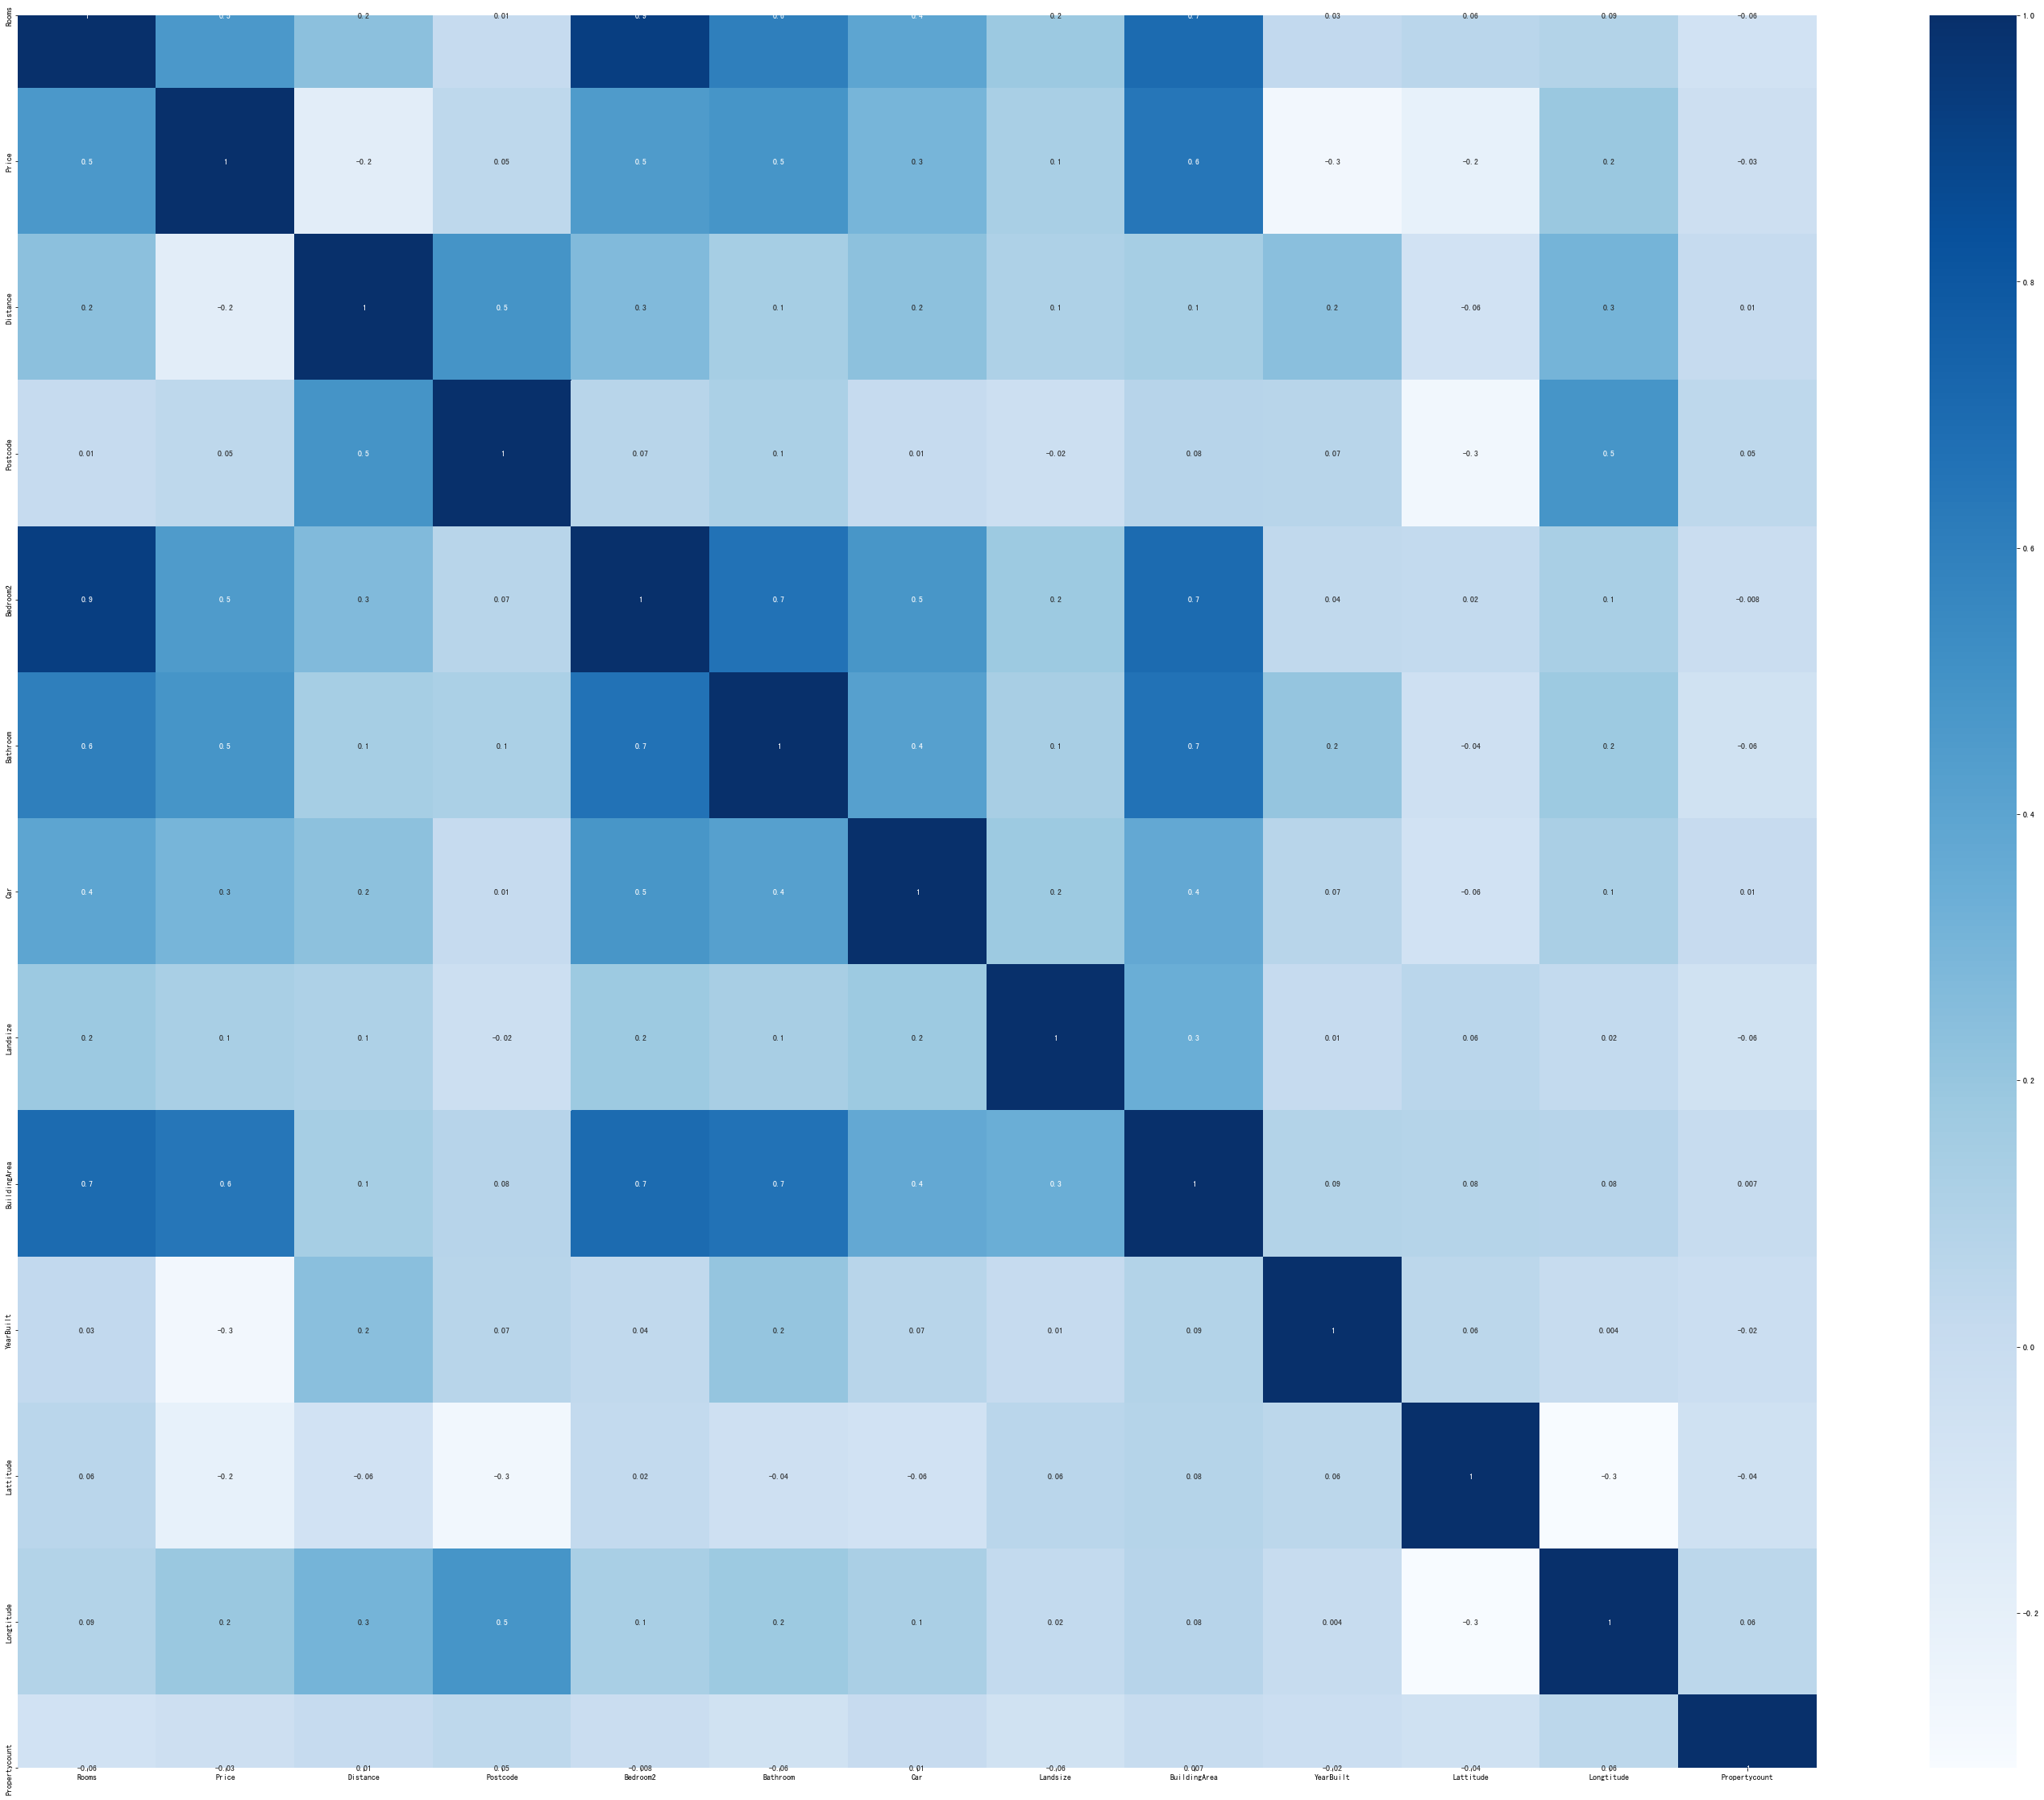

In [55]:
#Finding correlation of all the variables
plt.figure(figsize=(50,40))
sns.heatmap(data=data.corr(),annot=True,cmap='Blues',fmt='.1g')

plt.show()

##### HEATMAP
The correlation heatmap shows that House Prices have a correlation of 0.5 or higher with attributes: Bedroom, Bathroom, Building Area.

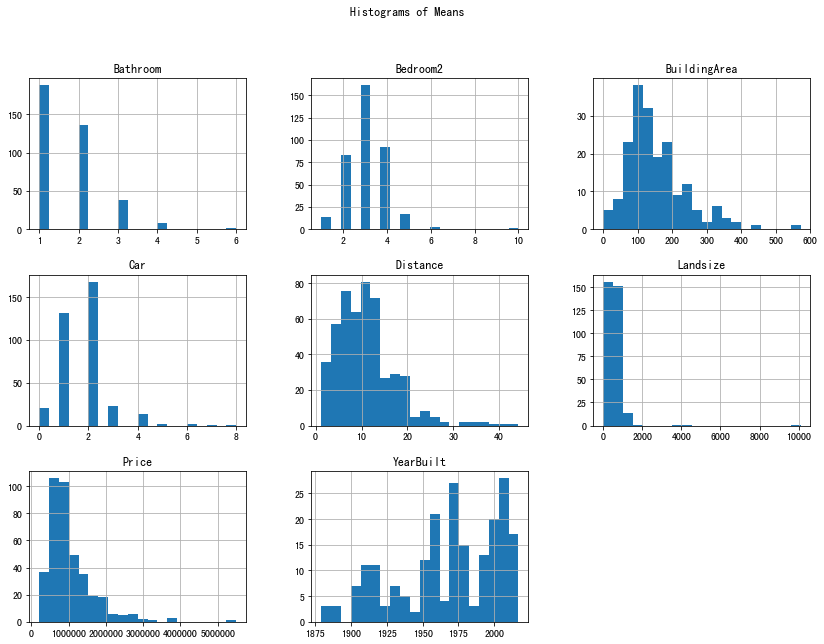

In [56]:
# Plot histograms with certain variables
attributes = ['Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize',
            'BuildingArea', 'YearBuilt']

## Histograms ##
data.hist(attributes, bins=20, figsize=(14,10))
plt.suptitle('Histograms of Means')

plt.show()

###### HISTOGRAMS

Bathroom, Bedroom2, Car: These variables are categorical and histograms are right-skewed, indicating a higher concentration of properties with fewer bathrooms, bedrooms, and car spaces. Which suggests this dataset has most properties in relatively smaller sizes. 

BuildingArea, Landsize: These are also right-skewed with a sharp decline as the area increases, suggesting that larger properties are rare and, again, this dataset has most properties in relatively smaller sizes. 

Price: This variable is also right-skewed, indicating most properties are on the more affordable side of scale in this dataset.

Distance: This histogram displays a right skew but with a more uniform distribution across distances, indicating that properties are available at varying distances from a particular point of interest, but closer properties are more common. 

YearBuilt: This distribution appears to be bimodal, with peaks in earlier and recent years, indicating significant building activity during these periods.

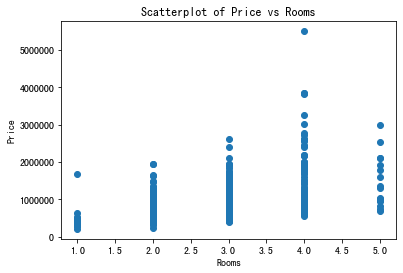

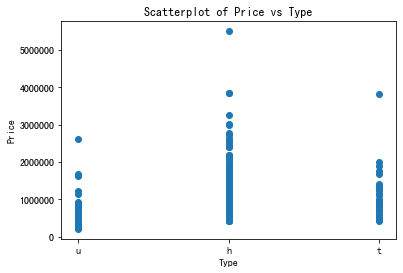

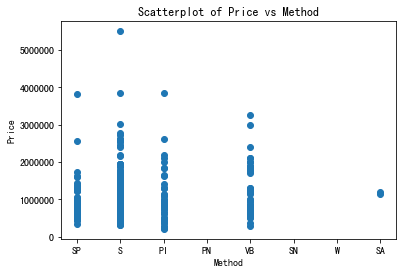

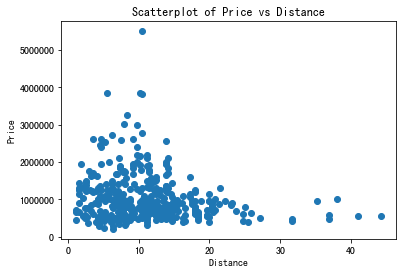

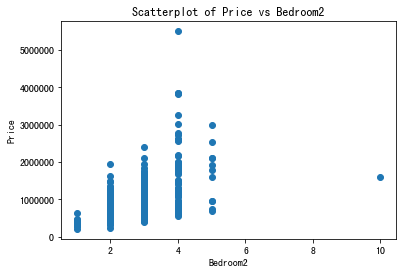

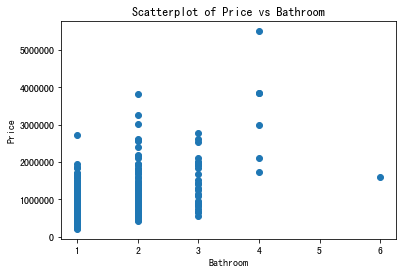

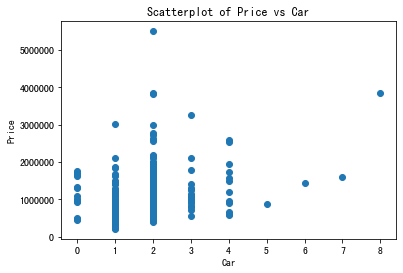

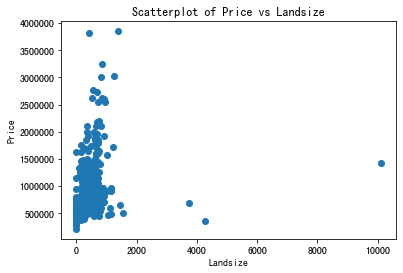

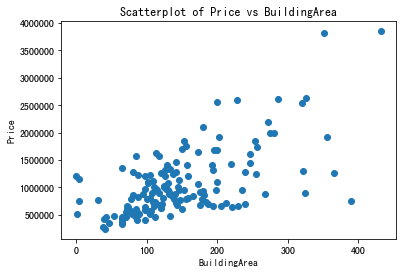

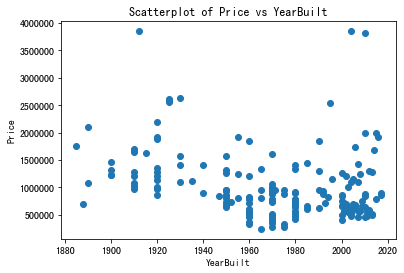

In [57]:
attributes = ['Rooms', 'Type', 'Method', 'Distance', 'Bedroom2',
              'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt']


for x_var in attributes:
    plt.scatter(data[x_var], data['Price'])
    plt.title(f'Scatterplot of Price vs {x_var}')
    plt.xlabel(x_var)
    plt.ylabel('Price')
    plt.show()

##### SCATTERPLOTS

Price vs Distance: There is a concentration of higher-priced properties with price generally decreasing with distance.

Price vs Landsize: Most of the properties are concentrated at relatively smaller landsizes with a lot of variabiity in price.

Price vs BuildingArea: We can see a linear correlation between these 2 variables. The larger the building area, the higher the price is.

### Question 2: Linear Regression Model Development

In [58]:
# remove unnecessary columns
columns_to_remove = ['Suburb', 'Address', 'Method', 'SellerG','Postcode',
                     'CouncilArea', 'Lattitude', 'Longtitude', 'Propertycount']
data = data.drop(columns=columns_to_remove)

In [1]:
# Filter columns that start with 'award'
award_columns = [col for col in final_df.columns if col.startswith('award')]

# Fill missing values in the selected columns with 0
final_df[award_columns].fillna(0)

NameError: name 'final_df' is not defined

In [59]:
# Handle missing values
data = data.fillna({'BuildingArea':data['BuildingArea'].mean(),
                    'Bedroom2':data['Bedroom2'].mean(),
                    'Bathroom':data['Bathroom'].mean(),
                    'Landsize':data['Landsize'].mean(),
                    'YearBuilt':data['YearBuilt'].median(),'Car':'0'})

# Drop NaN price values
data = data.dropna(subset=['Price'])

nulls = data.isnull().sum()
print(nulls)

Rooms           0
Type            0
Price           0
Date            0
Distance        0
Bedroom2        0
Bathroom        0
Car             0
Landsize        0
BuildingArea    0
YearBuilt       0
Regionname      0
dtype: int64


In [60]:
# change car variable to numberic
data['Car'] = pd.to_numeric(data['Car'], errors='coerce')

# change date to several columns
data['Date'] = pd.to_datetime(data['Date'])

data['month'] = data['Date'].dt.month
data['quarter'] = data['Date'].dt.quarter
data['year'] = data['Date'].dt.year

In [61]:
# use one-hot encoding to make dummy variables
data = pd.get_dummies(data, columns=['Type'], prefix='Type')
data = pd.get_dummies(data, columns=['Regionname'], prefix='Region')

In [62]:
data.head()

,Rooms,Price,Date,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,...,Type_t,Type_u,Region_Eastern Metropolitan,Region_Eastern Victoria,Region_Northern Metropolitan,Region_Northern Victoria,Region_South-Eastern Metropolitan,Region_Southern Metropolitan,Region_Western Metropolitan,Region_Western Victoria
0,2,438000.0,2016-08-22,6.5,2.000000,1.000000,1.0,0.0,66.000000,1970.0,...,0,1,0,0,1,0,0,0,0,0
1,2,901000.0,2016-06-27,7.8,2.000000,1.000000,1.0,545.0,107.000000,1940.0,...,0,0,0,0,1,0,0,0,0,0
2,3,800000.0,2016-05-28,13.9,3.000000,2.000000,2.0,261.0,152.461905,1970.0,...,0,1,0,0,0,0,0,1,0,0
3,3,1155000.0,2017-11-25,12.4,3.083558,1.649596,0.0,533.4,152.461905,1970.0,...,1,0,1,0,0,0,0,0,0,0
4,3,1630000.0,2016-10-09,3.3,3.000000,1.000000,1.0,0.0,152.461905,1970.0,...,0,1,0,0,0,0,0,1,0,0


- Removed columns that are not important, then handling missing values after. I did several different approach to the missing values depending on what variable is missing, including using mean, medean, and simply using 0.
- Made sure the value for 'Car' to numeric
- Seperated date to year, quarter, month, day of week
- Used label encoding for the categorical values, including columns 'Type' and 'Regionname'.

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [64]:
# Develop Linear Regression
y = data["Price"]
x = data.drop(["Price", "Date", "Type_u", "Region_Western Victoria"], axis=1)

In [65]:
results = sm.OLS(y, x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.890
Method:                 Least Squares   F-statistic:                              159.7
Date:                Thu, 01 Feb 2024   Prob (F-statistic):                   1.77e-168
Time:                        11:24:57   Log-Likelihood:                         -5590.6
No. Observations:                 391   AIC:                                  1.122e+04
Df Residuals:                     371   BIC:                                  1.130e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Rooms                               1.86e+05      4e+04      4.646      0.000    1.07e+05    2.65e+05
Distance                           -4.07e+04   4540.781     -8.962      0.000   -4.96e+04   -3.18e+04
Bedroom2                          -6.499e+04   4.44e+04     -1.464      0.144   -1.52e+05    2.23e+04
Bathroom                           2.299e+05   4.28e+04      5.367      0.000    1.46e+05    3.14e+05
Car                                5.789e+04   1.97e+04      2.940      0.003    1.92e+04    9.66e+04
Landsize                             41.8451     34.707      1.206      0.229     -26.401     110.091
BuildingArea                       1847.8712    486.329      3.800      0.000     891.565    2804.177
YearBuilt                         -4348.5272    996.747     -4.363      0.000   -6308.508   -2388.546
month                              -1.11e+04   2.85e+04     -0.390      0.697   -6.71e+04    4.49e+04
quarter                            1.906e+04   7.97e+04      0.239      0.811   -1.38e+05    1.76e+05
year                               4287.6385    981.582      4.368      0.000    2357.476    6217.801
Type_h                             4.442e+05   6.74e+04      6.588      0.000    3.12e+05    5.77e+05
Type_t                             2.958e+05   8.27e+04      3.576      0.000    1.33e+05    4.58e+05
Region_Eastern Metropolitan        6.595e+04   4.16e+05      0.159      0.874   -7.52e+05    8.84e+05
Region_Eastern Victoria            5.557e+05   4.53e+05      1.225      0.221   -3.36e+05    1.45e+06
Region_Northern Metropolitan      -1.905e+05   4.19e+05     -0.455      0.649   -1.01e+06    6.33e+05
Region_Northern Victoria           4.589e+05   5.76e+05      0.797      0.426   -6.74e+05    1.59e+06
Region_South-Eastern Metropolitan  2.672e+05   4.21e+05      0.634      0.526   -5.61e+05     1.1e+06
Region_Southern Metropolitan       3.219e+05   4.18e+05      0.769      0.442   -5.01e+05    1.14e+06
Region_Western Metropolitan       -2.219e+05   4.18e+05     -0.531      0.596   -1.04e+06    5.99e+05
==============================================================================
Omnibus:                      256.789   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3952.267
Skew:                           2.527   Prob(JB):                         0.00
Kurtosis:                      17.733   Cond. No.                     1.55e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+05. This might indic

### Question 3: Model Evaluation

In [66]:
#Creating the train, test split for our data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
results_training = sm.OLS(y_train, X_train).fit()

#Training model
print(results_training.summary())
y_pred = results_training.predict(X_test)

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.917
Method:                 Least Squares   F-statistic:                              172.6
Date:                Thu, 01 Feb 2024   Prob (F-statistic):                   9.55e-149
Time:                        11:24:57   Log-Likelihood:                         -4398.7
No. Observations:                 312   AIC:                                      8837.
Df Residuals:                     292   BIC:                                      8912.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [67]:
#Calculating the R-square
r_sq = r2_score(y_test, y_pred)

#Calculating the Root Mean Square Error (RMSE)
rmse = sqrt(mean_squared_error(y_test, y_pred))

print(f"The r-square of the model is {r_sq}, and the root mean square error is {rmse}.")

The r-square of the model is 0.4938911639590722, and the root mean square error is 607549.1370537024.


#### Interpretation:

Model Fit and Predictive Power:
The R-squared is 0.4939, suggesting that approximately 49.39% of the variability in prices can be explained by the model. This value indicates a moderate level of fit, which means that the model has a fair predictive ability but also leaves a substantial portion of the variance unexplained.

Prediction Accuracy:
The Root Mean Squared Error (RMSE) is 607549, indicating the average distance between the predicted prices and the actual prices in the dataset. The magnitude of this value suggests that the model's predictions can vary quite significantly from actual values.

Statistical Significance:
The model summary shows coefficients for each variable along with their standard errors and significance levels. Significant variables like 'Rooms', 'BuildingArea', and 'YearBuilt' etc. have p-values less than 0.05, indicating a statistically significant relationship with the prices. On the other hand, some variables like 'Bedroom2' and the regions have p-values greater than 0.05, suggesting that their relationships with prices might not be statistically significant.

### Question 4: Regularization

In [68]:
from sklearn.linear_model import ElasticNet, Lasso, LassoCV, BayesianRidge, LassoLarsIC
from sklearn.preprocessing import StandardScaler

There is a need of lasso regularization because looking both at the r-squared and RMSE from the linear model suggest that there are some overfitting due to unnecessary variables not generalize weel OOS. That is where lasso can help.

In [69]:
#Scaling the X values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Creating the lambda test values
alphas = np.logspace(-6, 0, 100)

#Creating 5 folds
k = 5
n = len(y_train)

#Shuffling the data
indices = np.arange(n)
np.random.shuffle(indices)

X_cv = X_train_scaled[indices]
y_cv = y_train.iloc[indices]

avg_rmse=[]
for alpha in alphas:
    rmse_list = []
    
    # Manual k-fold splitting
    for fold in range(k):
        # Calculating the size of each fold
        fold_size = n // k
        
        # Define the start and end indices of the test set
        start, end = fold * fold_size, (fold + 1) * fold_size
        
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))
        
        X_train_cv, X_test_cv = X_cv[train_indices], X_cv[test_indices]
        y_train_cv, y_test_cv = y_cv.iloc[train_indices], y_cv.iloc[test_indices]
        
        lasso = Lasso(alpha=alpha)
        
        lasso.fit(X_train_cv, y_train_cv)
        
        y_pred_cv = lasso.predict(X_test_cv)
        rmse = np.sqrt(mean_squared_error(y_test_cv, y_pred_cv))
        
        rmse_list.append(rmse)
        
    avg_rmse.append(np.mean(rmse_list))

#Finding the best alpha
best_alpha = alphas[np.argmin(avg_rmse)]
print(f"Best alpha: {best_alpha}")

lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train_scaled, y_train)

y_pred = lasso.predict(X_test_scaled)

rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"The R-sqaure is {r2} and the rmse is {rmse}")

#Getting the coefficients and intercept from the lasso regression
coefficients = lasso.coef_
intercept = lasso.intercept_

Best alpha: 1.0
The R-sqaure is 0.5001236564758202 and the rmse is 603796.7078362869


#### Interpretation
Looking at the R-square and RMSE almost the same as from the Linear regression, we can know that Lasso regression in this case failed show any significant improvement in predicting the prices compared to Linear Regression. This may due to lasso penalizing our variables, and there may be some other unknown variables that the dataset did not have that can better predict the price. 


### Question 5: Out-of-sample Performance

In [70]:
##split data to 80-20
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [71]:
# Linear Regression Model
model = sm.OLS(y_train,sm.add_constant(X_train)).fit()

# Lasso Regression Model
model_lasso = Lasso(alpha= 1)
model_lasso.fit(X_train, y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [72]:
# Estimate AIC, AICc, BIC, as well as 5-fold CV for linear regression model using only the training data.

# aic
aic = model.aic

# aicc
n_obs = len(y_train)
n_parameter = model.df_model + 1
aicc = aic + (2 * n_parameter * (n_parameter+1))/(n_obs - n_parameter - 1)

#bic
bic = model.bic

print(f'AIC is {aic}') 
print(f'AICc is {aicc}') 
print(f'BIC is {bic}') 

# 5-fold cv
fold_5 = KFold(n_splits=5, shuffle = True, random_state= 12)
model_MSRE = cross_val_score(LinearRegression(), X_train, y_train, cv = fold_5, scoring = make_scorer(mean_squared_error))
model_MSRE = np.mean(model_MSRE)
print(f'Mean Squared Error for Linear Regression model using training data is {model_MSRE}.')

AIC is 8953.770471246124
AICc is 8956.956678142675
BIC is 9032.373538190122
Mean Squared Error for Linear Regression model using training data is 185315469008.06708.


In [73]:
# Estimate AIC, AICc, BIC, as well as 5-fold CV for Lasso regression model using only the training data. we have to mannaully calculate Aic, Aicc and Bic

# find mse from training data
y_pred_train = model_lasso.predict(X_train)
rss = np.sum((y_train - y_pred_train) ** 2)


# getting k and n ready for calculating AIC, AICc and BIC
n = len(y_test)
k = X_train.shape[1] + 1  # Number of parameters including the intercept

# AIC
aic_lasso = n * np.log( rss / n ) + 2 * k

# AICc
aicc_lasso = n * np.log( rss / n ) + 2 * k + (2 * k * (k + 1)) / (n - k - 1)

# BIC
bic_lasso = n * np.log( rss / n ) + k * np.log(n)

print(f'AIC for Lasso model is {aic_lasso}')
print(f'AICc for Lasso model is {aicc_lasso}')
print(f'BIC for Lasso model is {bic_lasso}')

# 5-fold cv
fold_5 = KFold(n_splits=5, shuffle = True, random_state= 12)
model_lasso_MSRE = cross_val_score(model_lasso, X_train, y_train, cv = fold_5, scoring = make_scorer(mean_squared_error))
model_lasso_MSRE = np.mean(model_lasso_MSRE)
print(f'Mean Squared Error for Lasso Regression model using training data is {model_lasso_MSRE}.')

AIC for Lasso model is 2182.824569779879
AICc for Lasso model is 2199.0350960956685
BIC for Lasso model is 2232.582974681686
Mean Squared Error for Lasso Regression model using training data is 185110336339.64886.


In [74]:
def deviance(y, pred, family="gaussian"):
    if family == "gaussian":
        return np.sum((y - pred) ** 2)
    elif family == "binomial":
        y = np.array(y)
        pred = np.array(pred)
        return -2 * np.sum(y * np.log(pred) + (1 - y) * np.log(1 - pred))

In [75]:
# Estimate the models true OOS performance by computing their deviance on the test data.

# linear rergession model
y_pred_test_linear = model.predict(sm.add_constant(X_test))
linear_model_deviance = deviance(y_test, y_pred_test_linear)

# Lasso rergession model
y_pred_test_lasso = model_lasso.predict(X_test)
lasso_model_deviance = deviance(y_test, y_pred_test_lasso)

print(f'The deviance on the test data for Linear regression model is {linear_model_deviance}.')
print(f'The deviance on the test data for Lasso regression model is {lasso_model_deviance}.')

The deviance on the test data for Linear regression model is 13749589726496.172.
The deviance on the test data for Lasso regression model is 13749407182675.932.


#### Interpretation
After retraining both linear and lasso regression models on the training data, we estimated AIC, AICc, BIC, and 5-fold CV for both models. Then we found deviance using test data for both models as well.

- Looking at the IC scores, we can see that the lasso model has lower scores compared to linear model, which indicates better OOS performance and better model overall.

- Looking at the deviance for both models, we can see that the lasso model has a lower deviance value on the test data, which suggests that the lasso model does a better job fitting out-of-sample.

To conclude, from the IC scores, MSE, and deviance of the two models, we can see that the lasso model is more effective.